In [1]:
'''
NOTE: THIS FILE IS FOR DAY, WEEK, MONTH
'''

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.tseries.offsets import MonthBegin
from sklearn.metrics import mean_squared_error


## Load data

df_rev = pd.read_csv('/Users/mwirvine/Galvanize/dsi-immersive/one-source-capstone/Data Feeds/ONE - Revenue Data.txt', sep='|')

## Filter on category 20 (booms, scissors, etc), remove credit txns (don't consider invoice credit txns in demand prediction)

df_rev = df_rev[df_rev['Client Category'] == 20]
df_rev = df_rev[df_rev['Rental Revenue'] > 0]

# Keep product types that make up ~95% of revenue, which is 30 of 60 types

top_equipment = ['20-873', '20-925', '20-847', '20-220', '20-720', '20-740', '20-240', '20-530', '20-810', '20-840', '20-760', '20-820', '20-890', '20-870', '20-580', '20-270', '20-842', '20-610', '20-210', '20-170', '20-910', '20-940', '20-430', '20-865', '20-860', '20-260', '20-310', '20-565', '20-812', '20-730', '20-350', '20-926']

df_rev = df_rev[df_rev['Client Product Type'].isin(top_equipment)]

## Drop and reformat columns

cols_to_drop = ['Client Code', 'Client Region', 'CreditAmount', 'Client District', 'Client Category', 'Country', 'Equipment ID #', 'IsSubstitution', 'Description', 'Transaction ID #', 'IsRPO', 'NationalAcctCode', 'Sales Rep #', 'Sales Rep Name', 'Customer Name', 'Minimums', 'IsNationalAcct', 'IsSpecialPricing', 'IsContract', 'ContractPriceNo', 'CycleBillNo', 'Jobsite ZipCode', 'Branch ZipCode', 'CustomerCorpID', 'Customer #', 'Minimum Revenue', 'Minimum Book Revenue']

df_rev.drop(cols_to_drop, axis=1, inplace=True)

cols = df_rev.columns.tolist()
cols = [col.lower() for col in cols]
cols = [col.replace(' ', '_') for col in cols]
df_rev.columns = cols

df_rev.rename(columns={'client_category': 'product_category', 'client_product_type': 'product_type'}, inplace=True)

## Reformat date columns

df_rev['month'] = pd.to_datetime(df_rev['month'])

## Drop data up until Oct 2014 (all of nulls in contract start date prior to this)

df_rev = df_rev.loc[df_rev['month'] > '2014-10-01', :]

## Reformat ContractStartDate date columns and drop 2013/2014 start dates

df_rev['contractstartdate'] = pd.to_datetime(df_rev['contractstartdate'])
df_rev = df_rev[df_rev['contractstartdate'] >= '2014-10-01']

## Clean up location codes

df_rev['location_code'].replace(['001'], 100, inplace=True)
df_rev['location_code'].replace(['002'], 200, inplace=True)
df_rev['location_code'].replace(['003'], 300, inplace=True)
df_rev['location_code'].replace(['004'], 400, inplace=True)
df_rev['location_code'].replace(['005'], 500, inplace=True)
df_rev['location_code'].replace(['006'], 600, inplace=True)
df_rev['location_code'].replace(['007'], 700, inplace=True)
df_rev['location_code'].replace(['008'], 800, inplace=True)
df_rev['location_code'].replace(['009'], 900, inplace=True)
df_rev['location_code'].replace(['101'], 101, inplace=True)
df_rev['location_code'].replace(['103'], 103, inplace=True)
df_rev['location_code'].replace(['201'], 201, inplace=True)
df_rev['location_code'].replace(['301'], 301, inplace=True)
df_rev['location_code'].replace([1], 100, inplace=True)
df_rev['location_code'].replace([2], 200, inplace=True)
df_rev['location_code'].replace([3], 300, inplace=True)
df_rev['location_code'].replace([4], 400, inplace=True)
df_rev['location_code'].replace([5], 500, inplace=True)
df_rev['location_code'].replace([6], 600, inplace=True)
df_rev['location_code'].replace([7], 700, inplace=True)
df_rev['location_code'].replace([8], 800, inplace=True)
df_rev['location_code'].replace([9], 900, inplace=True)

# Remove two corporate rental invoices (not needed with reduced product types)
df_rev = df_rev[df_rev['location_code'] != 'COR']

# fill NaNs with 0s (can do this because all NaNs represent zero (e.g., if monthly rental has zero
# weekly revenue, can put weekly rental as 0))

df_rev.fillna(0, inplace=True)

# Remove three hourly rental invoices

df_rev = df_rev[df_rev['hours'] == 0]
df_rev.drop(['hourly_revenue', 'hourly_book_revenue', 'hours'], axis=1, inplace=True)

# Change column to a numeric column

df_rev['location_code'] = pd.to_numeric(df_rev['location_code'])

# Create branch name column (for a dummy later)

conditions = [
    df_rev['location_code'] == 100,
    df_rev['location_code'] == 200,
    df_rev['location_code'] == 300,
    df_rev['location_code'] == 400,
    df_rev['location_code'] == 500,
    df_rev['location_code'] == 600,
    df_rev['location_code'] == 700,
    df_rev['location_code'] == 800,
    df_rev['location_code'] == 900,
    df_rev['location_code'] == 101,
    df_rev['location_code'] == 103,
    df_rev['location_code'] == 201,
    df_rev['location_code'] == 301]

choices = ['LAF', 'KNX', 'DEC', 'GRA', 'MOR', 'TER', 'LOU', 'IND', 'CLA', 'LAF-NUC', 'DEC-STA', 'LAF-FRE', 'LAF-SDI']
df_rev['branch_name'] = np.select(conditions, choices, default='TBD')

# create rental type column (rental was monthly, weekly, daily)

conditions = [
    df_rev['days'] > 0,
    df_rev['weeks'] > 0,
    df_rev['months'] > 0]

choices = ['daily', 'weekly', 'monthly']
df_rev['rental_type'] = np.select(conditions, choices, default='NA')

# Remove unclassified revenue records (< 300 records total

df_rev = df_rev.loc[df_rev['rental_type'] != 'NA', :]

# Remove excessmileagerevenue and unclassifiedrevenue (< 300 records have these filled)

df_rev.drop(['excessmileagerevenue', 'unclassifiedrevenue'], axis=1, inplace=True)

# create contract start month, year, and year_month columns

df_rev['contract_start_year'] = df_rev['contractstartdate'].dt.year
df_rev['contract_start_month'] = df_rev['contractstartdate'].dt.month
df_rev['contract_start_year_month'] = pd.to_datetime(df_rev['contractstartdate']).map(lambda dt: dt.replace(day=1))

# create units_rented columns (will be target variable)

df_rev['units_rented'] = 1

# create total days rented column for daily, weekly, monthl rentals

for idx, row in df_rev.iterrows():
    if row['rental_type'] == 'daily':
        df_rev.loc[idx, 'total_days_rented'] = row['days']
    elif row['rental_type'] == 'weekly':
        df_rev.loc[idx, 'total_days_rented'] = row['weeks'] * 6
    elif row['rental_type'] == 'monthly':
        df_rev.loc[idx, 'total_days_rented'] = row['months'] * 28

# Create aggregated dataset and price per day

df_agg = df_rev.groupby(['product_type', 'contract_start_year_month', 'contract_start_year', 'contract_start_month', 'rental_type']).agg({'rental_revenue':'sum', 'total_days_rented': 'sum', 'units_rented':'count'}).reset_index()
df_agg['avg_price_per_day'] = df_agg['rental_revenue'] / df_agg['total_days_rented']

# Create lag columns (prior month units rented, revenue, etc.)

df_agg.sort_values('contract_start_year_month', inplace=True)
df_agg.reset_index(drop=True, inplace=True)

def get_month_lag(df, row):
    lag_date = row['contract_start_year_month'] - 1 * MonthBegin()
    mask = (lag_date == df.loc[:, 'contract_start_year_month']) & (row['product_type'] == df.loc[:, 'product_type']) & (row['rental_type'] == df.loc[:, 'rental_type'])
    lag_df = df.loc[mask, :]
    return lag_df

df_agg['prior_month_rental_revenue'] = 0
df_agg['prior_month_total_days_rented'] = 0
df_agg['prior_month_units_rented'] = 0
df_agg['prior_month_avg_price_per_day'] = 0

for idx, row in df_agg.iterrows():
    lag_df = get_month_lag(df_agg, row)
    if lag_df.empty:
        df_agg.loc[idx, 'prior_month_rental_revenue'] = None
        df_agg.loc[idx, 'prior_month_total_days_rented'] = None
        df_agg.loc[idx, 'prior_month_units_rented'] = None
        df_agg.loc[idx, 'prior_month_avg_price_per_day'] = None
    else:
        df_agg.loc[idx, 'prior_month_rental_revenue'] = lag_df['rental_revenue'].values
        df_agg.loc[idx, 'prior_month_total_days_rented'] = lag_df['total_days_rented'].values
        df_agg.loc[idx, 'prior_month_units_rented'] = lag_df['units_rented'].values
        df_agg.loc[idx, 'prior_month_avg_price_per_day'] = lag_df['avg_price_per_day'].values

# remove October 2014 data as there is no prior month
df_agg = df_agg.loc[df_agg['contract_start_year_month'] > '2014-10-01', :]
df_agg.reset_index(drop=True, inplace=True)

# fill NaNs for prior month features with zeros as there was no prior month rental revenue

df_agg.fillna(0, inplace=True)

# drop current month columns as we only have prior month to predict

df_agg.drop(['rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1, inplace=True)

# Dummy function

def create_dummies(dummy_col, df, col_prefix):
    dum_col = df[dummy_col]
    dummies = pd.get_dummies(dum_col, prefix=col_prefix)
    df = df.drop([dummy_col], axis=1)
    df_w_dummies = df.merge(dummies, left_index=True, right_index=True)
    return df_w_dummies

# Create dummies

df_agg = create_dummies('product_type', df_agg, 'product_type')
df_agg = create_dummies('contract_start_year', df_agg, 'contract_start_year')
df_agg = create_dummies('contract_start_month', df_agg, 'contract_start_month')
df_agg = create_dummies('rental_type', df_agg, 'rental_type')


# create train / test sets (test will be May 2017 - April 2018)
# (train will be Nov 2014 - April 2017) note: may-july 2018 look sparse

df_agg = df_agg.loc[df_agg['contract_start_year_month'] < '2018-05-01', :]

df_agg_test = df_agg.loc[df_agg['contract_start_year_month'] >= '2017-05-01', :]
df_agg_train = df_agg.loc[df_agg['contract_start_year_month'] < '2017-05-01', :]

df_agg_test.drop('contract_start_year_month', axis=1, inplace=True)
df_agg_train.drop('contract_start_year_month', axis=1, inplace=True)

## model functions

def calc_rmse(true, predicted):
    residuals_squared = (predicted - true)**2
    variance = sum(residuals_squared) / len(true)
    rmse = np.sqrt(variance)
    return rmse

### Model Execution ###

# Create X,y matrices

X_train = df_agg_train.drop('units_rented', axis=1).values
y_train = df_agg_train['units_rented'].values
X_test = df_agg_test.drop('units_rented', axis=1).values
y_test = df_agg_test['units_rented'].values


# Standardize data

standardizer = StandardScaler()
standardizer.fit(X_train, y_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

del X_train
del X_test

# Linear Regression

linear = LinearRegression()
linear.fit(X_train_std, y_train)
y_pred_train_linear = linear.predict(X_train_std)
y_pred_test_linear = linear.predict(X_test_std)
r_squared_linear = linear.score(X_train_std, y_train)
rmse_linear_train = calc_rmse(y_train, y_pred_train_linear)
rmse_linear_test = calc_rmse(y_test, y_pred_test_linear)

lin_mse = mean_squared_error(y_test, y_pred_test_linear)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

print("Linear RMSE train results: {}".format(rmse_linear_train))
print("Linear RMSE test results: {}".format(rmse_linear_test))

# Random Forest

rf = RandomForestRegressor(n_estimators=250, max_features='sqrt', n_jobs=-1, min_samples_leaf=1, min_samples_split=2)
rf.fit(X_train_std, y_train)
y_pred_train_rf = rf.predict(X_train_std)
y_pred_test_rf = rf.predict(X_test_std)
r_squared_rf = rf.score(X_test_std, y_test)
rmse_rf_train = calc_rmse(y_train, y_pred_train_rf)
rmse_rf_test = calc_rmse(y_test, y_pred_test_rf)

print("RF RMSE train results: {}".format(rmse_rf_train))
print("RF RMSE test results: {}".format(rmse_rf_test))

'''
Next steps for tomorrow:
- keep same feature matrix but standardize and try a few different models (RF, ridge, lasso, boosting, etc.)
- if other models aren't working well either, then try reducing features (top ten product_types only, remove year dimension)
or try adding a couple new featuers (external construction spend, etc). Could also try clustering
- what other features?
    - external construction spend
    - rerents?
- open questions:
    - best approach to put EDA / data cleansing in a class? or pickle the cleansed / enriched dataframe and load into another file?
    - drop may, june and july 2018 as it seems sparse compared to prior years?
    - dimensionality reduction?
- plots to inspect data more
    - total revenue over time (see if it changes much the last couple years - if not, could drop year feature)
    - total units / revenue by rented by product type (show how few products are rented the most). 80/20 rule. CREATE CHART/GRAPH FOR README
    - correlation matrix / table
- example to clean code on wed:
    - https://github.com/ecgill/flip_risk_indexer
'''

'''
Model testing / tuning results:

1) Full feature matrix - month only - linear rmse - 13.5. RF rmse - 15
RF looks to be overfitting as train is 5.64 and test is 15. Linear doesn't look
to be overfitting as train and test are ~13.5

2) Same as above, but with standardization. RF the same. Linear test rmse is enormous now...what is happening?

3) Reduced product category from to top 30 pieces of equipment by revenue out of 60 total types. Top 30 pieces make up ~95% of revenue. Also tried 80/20 rule which was 17 pieces of equipment. Similar results. Linear rmse train / test = 15.65 / billions. RF train / test = 6.47 / 17

4) removed contract start year as a variable...results about the same except linear test is now not off the charts. Linear rmse test = 15.4. Not sure if it makes sense to do this as now what does "prior month" mean if there is no year associated. why did standardization for linear test get better?



'''

# open question: aggregate on contract_start_year_month - agreed with mike to agg on contract start dates

## CLEAN UP:
# change my masks to .loc per Mike

# next steps: remove location_code, contractstartdate
# get dummies on product type, rental_type, branch_name
# make some demand and rev plots by contract start month (across years)
# this should help me figure out how to aggregate (thinking about model for whole company first)
# features to engineer (after i run simpler model)
# rerent revenue as % of total revenue by cat/class
# total rerents by cat/class (mark each invoice as rerent or not)
# avg monthly, weekly, daily price by cat/class
# total days on rent by cat/class
# external construction spend data


/Users/mwirvine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mwirvine/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


17496139136745.213
Linear RMSE train results: 11.74125847343613
Linear RMSE test results: 17496139136745.223
RF RMSE train results: 4.084006862746662
RF RMSE test results: 10.710169094395026


'\nModel testing / tuning results:\n\n1) Full feature matrix - month only - linear rmse - 13.5. RF rmse - 15\nRF looks to be overfitting as train is 5.64 and test is 15. Linear doesn\'t look\nto be overfitting as train and test are ~13.5\n\n2) Same as above, but with standardization. RF the same. Linear test rmse is enormous now...what is happening?\n\n3) Reduced product category from to top 30 pieces of equipment by revenue out of 60 total types. Top 30 pieces make up ~95% of revenue. Also tried 80/20 rule which was 17 pieces of equipment. Similar results. Linear rmse train / test = 15.65 / billions. RF train / test = 6.47 / 17\n\n4) removed contract start year as a variable...results about the same except linear test is now not off the charts. Linear rmse test = 15.4. Not sure if it makes sense to do this as now what does "prior month" mean if there is no year associated. why did standardization for linear test get better?\n\n\n\n'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
corr_matrix = df_agg_train.corr()
corr_matrix['units_rented'].sort_values(ascending=False)

units_rented                     1.000000
prior_month_units_rented         0.818540
prior_month_total_days_rented    0.779490
product_type_20-220              0.576088
prior_month_rental_revenue       0.392598
rental_type_monthly              0.328858
product_type_20-240              0.239280
product_type_20-720              0.111010
product_type_20-270              0.062832
product_type_20-530              0.040690
product_type_20-210              0.038355
product_type_20-847              0.030311
contract_start_month_11          0.015869
contract_start_month_10          0.015419
product_type_20-170              0.015001
product_type_20-740              0.010676
contract_start_year_2014         0.009131
product_type_20-580              0.006525
contract_start_month_6           0.006439
contract_start_month_3           0.005554
product_type_20-810              0.005227
contract_start_month_12          0.004412
contract_start_month_7           0.003482
contract_start_year_2017         0

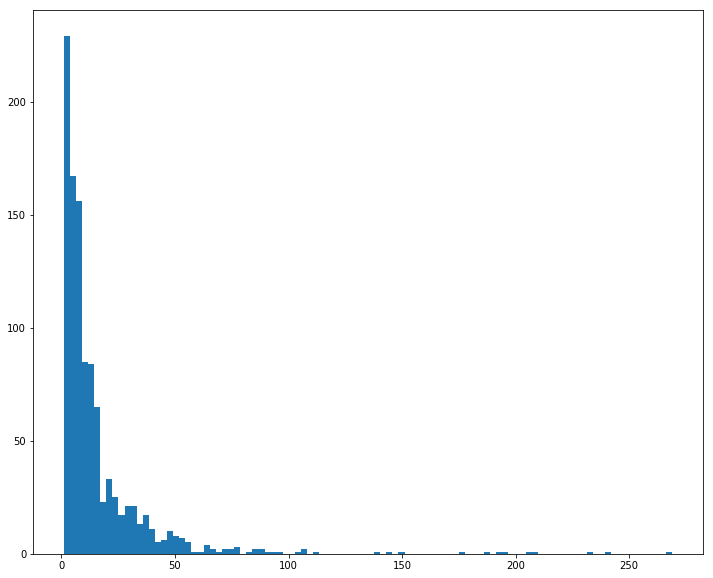

In [24]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.hist(y_test, bins=100);

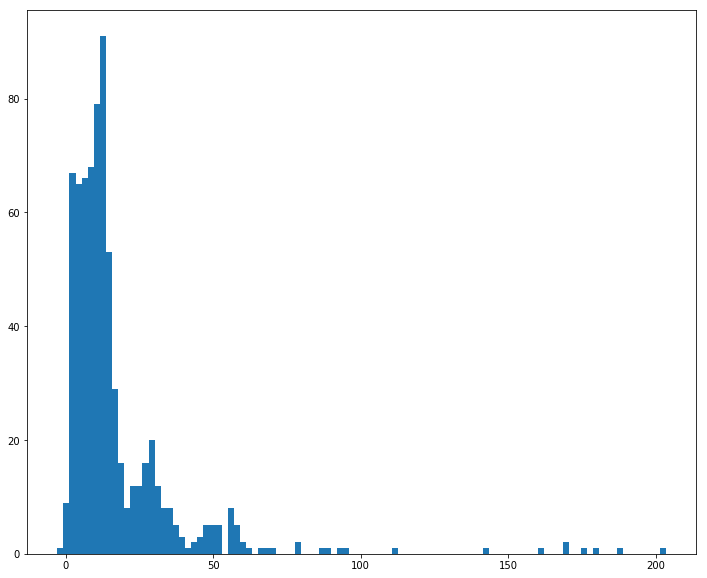

In [23]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.hist(y_pred_test_linear[y_pred_test_linear < 100000], bins=100);
#ax.set_xscale('log');